In [2]:
import io

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

import ipywidgets as widgets  # interactive display


In [3]:
def plot_isis(single_neuron_isis):
    plt.hist(single_neuron_isis, bins=50, histtype="stepfilled")
    plt.axvline(single_neuron_isis.mean(), color="orange", label="Mean ISI")
    plt.xlabel("ISI duration (s)")
    plt.ylabel("Number of spikes")
    plt.legend()

In [4]:
spike_times = np.load(io.BytesIO(open("data/nma_steinmetz_spiketimes_cori_20161214_f32.npz", "rb").read()), allow_pickle=True)["spike_times"]

In [5]:
print(type(spike_times))
print(spike_times.shape)
num_neurons = len(spike_times)
num_spikes_per_neuron = [len(neuron) for neuron in spike_times]

<class 'numpy.ndarray'>
(734,)


% below mean: 67.98%


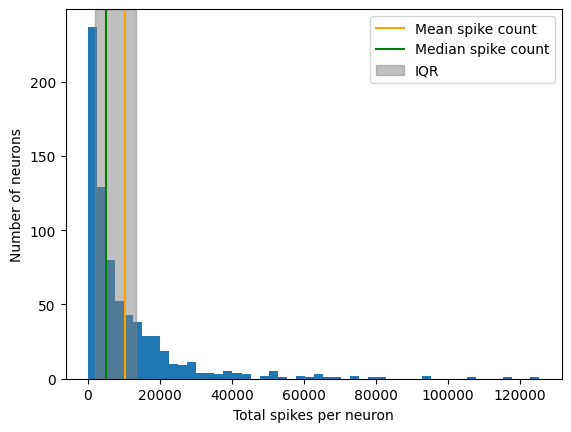

In [6]:
mean = np.mean(num_spikes_per_neuron)
median = np.median(num_spikes_per_neuron)
p_25 = np.percentile(num_spikes_per_neuron, 25)
p_75 = np.percentile(num_spikes_per_neuron, 75)
frac_below_mean = np.mean(num_spikes_per_neuron < mean) # Returns a boolean array
print(f"% below mean: {frac_below_mean:.2%}")

plt.figure()
plt.hist(num_spikes_per_neuron, bins=50, histtype="stepfilled")
plt.axvline(mean, color="orange", label="Mean spike count")
plt.axvline(median, color="green", label="Median spike count")
plt.axvspan(p_25, p_75, color="gray", alpha=0.5, label="IQR")
plt.xlabel("Total spikes per neuron")
plt.ylabel("Number of neurons")
plt.legend()

In [7]:
# @markdown Execute this cell for helper function `restrict_spike_times`
def restrict_spike_times(spike_times, interval):
    """Given a spike_time dataset, restrict to spikes within given interval.
  
    Args:
      spike_times (sequence of np.ndarray): List or array of arrays,
        each inner array has spike times for a single neuron.
      interval (tuple): Min, max time values; keep min <= t < max.
  
    Returns:
      np.ndarray: like `spike_times`, but only within `interval`
    """
    interval_spike_times = []
    for spikes in spike_times:
        interval_mask = (spikes >= interval[0]) & (spikes < interval[1])
        interval_spike_times.append(spikes[interval_mask])
    return np.array(interval_spike_times, object)

In [8]:
t_interval = (5, 15)  # units are seconds after start of recording
interval_spike_times = restrict_spike_times(spike_times, t_interval)

original_counts = sum([len(spikes) for spikes in spike_times])
interval_counts = sum([len(spikes) for spikes in interval_spike_times])
frac_interval_spikes = interval_counts / original_counts
print(f"{frac_interval_spikes:.2%} of the total spikes are in the interval")

0.33% of the total spikes are in the interval


In [9]:
# Calculate the experiment duration
all_spikes = np.concatenate(spike_times)
experiment_duration = np.ptp(all_spikes)
interval_duration = t_interval[1] - t_interval[0]
frac_interval_time = interval_duration / experiment_duration
print(f"{frac_interval_time:.2%} of the total time is in the interval")

0.37% of the total time is in the interval


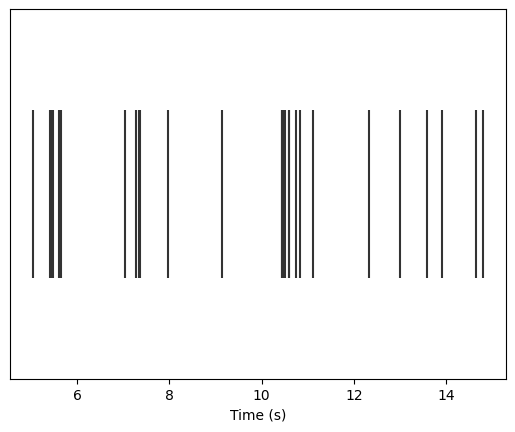

In [10]:
neuron_idx = 1
plt.eventplot(interval_spike_times[neuron_idx], color=".2")
plt.xlabel("Time (s)")
plt.yticks([]);


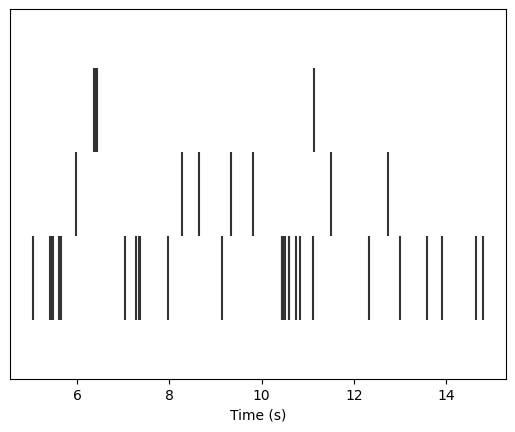

In [11]:

neuron_idx = [1, 11, 51]
plt.eventplot(interval_spike_times[neuron_idx], color=".2")
plt.xlabel("Time (s)")
plt.yticks([]);

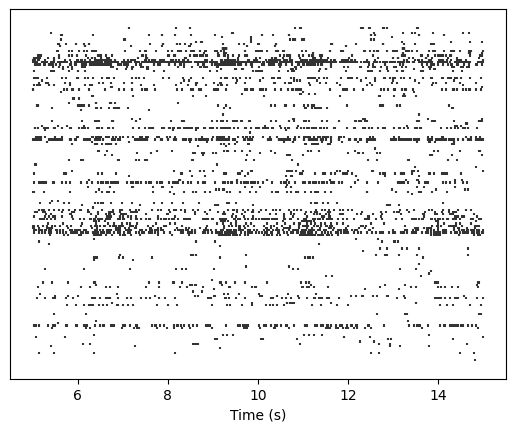

In [12]:
neuron_idx = np.arange(0, len(spike_times), 5)
plt.eventplot(interval_spike_times[neuron_idx], color=".2")
plt.xlabel("Time (s)")
plt.yticks([]);

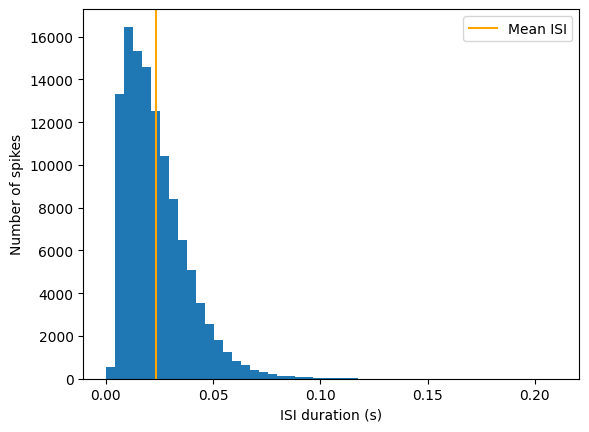

In [13]:
def compute_single_neuron_isis(spike_times, neuron_idx):
    """Compute a vector of ISIs for a single neuron given spike times.
  
    Args:
      spike_times (list of 1D arrays): Spike time dataset, with the first
        dimension corresponding to different neurons.
      neuron_idx (int): Index of the unit to compute ISIs for.
  
    Returns:
      isis (1D array): Duration of time between each spike from one neuron.
    """
    # Extract the spike times for the specified neuron
    single_neuron_spikes = spike_times[neuron_idx]

    # Compute the ISIs for this set of spikes
    # Hint: the function np.diff computes discrete differences along an array
    isis = np.diff(single_neuron_spikes)

    return isis

# Compute ISIs
single_neuron_isis = compute_single_neuron_isis(spike_times, neuron_idx=283)

# Visualize ISIs
plot_isis(single_neuron_isis)

In [14]:
def exponential(xs, scale, rate, x0):
    """A simple parameterized exponential function, applied element-wise.
  
    Args:
      xs (np.ndarray or float): Input(s) to the function.
      scale (float): Linear scaling factor.
      rate (float): Exponential growth (positive) or decay (negative) rate.
      x0 (float): Horizontal offset.
  
    """
    ys = scale * np.exp(rate * (xs - x0))
    return ys

def inverse(xs, scale, x0):
    """A simple parameterized inverse function (`1/x`), applied element-wise.
  
    Args:
      xs (np.ndarray or float): Input(s) to the function.
      scale (float): Linear scaling factor.
      x0 (float): Horizontal offset.
  
    """
    ys = scale / (xs - x0)
    return ys

def linear(xs, slope, y0):
    """A simple linear function, applied element-wise.
  
    Args:
      xs (np.ndarray or float): Input(s) to the function.
      slope (float): Slope of the line.
      y0 (float): y-intercept of the line.
  
    """
    ys = slope * xs + y0
    return ys

In [15]:
#@markdown Be sure to run this cell to enable the demo
# Don't worry about understanding this code! It's to setup an interactive plot.
single_neuron_idx = 283
single_neuron_spikes = spike_times[single_neuron_idx]
single_neuron_isis = np.diff(single_neuron_spikes)

counts, edges = np.histogram(
    single_neuron_isis,
    bins=50,
    range=(0, single_neuron_isis.max())
)

functions = dict(
    exponential=exponential,
    inverse=inverse,
    linear=linear,
)

colors = dict(
    exponential="C1",
    inverse="C2",
    linear="C4",
)

@widgets.interact(
    exp_scale=widgets.FloatSlider(1000, min=0, max=20000, step=250),
    exp_rate=widgets.FloatSlider(-10, min=-200, max=50, step=1),
    exp_x0=widgets.FloatSlider(0.1, min=-0.5, max=0.5, step=0.005),
    inv_scale=widgets.FloatSlider(1000, min=0, max=3e2, step=10),
    inv_x0=widgets.FloatSlider(0, min=-0.2, max=0.2, step=0.01),
    lin_slope=widgets.FloatSlider(-1e5, min=-6e5, max=1e5, step=10000),
    lin_y0=widgets.FloatSlider(10000, min=0, max=4e4, step=1000),
)
def fit_plot(
        exp_scale=1000, exp_rate=-10, exp_x0=0.1,
        inv_scale=1000, inv_x0=0,
        lin_slope=-1e5, lin_y0=2000,
):
    """Helper function for plotting function fits with interactive sliders."""
    func_params = dict(
        exponential=(exp_scale, exp_rate, exp_x0),
        inverse=(inv_scale, inv_x0),
        linear=(lin_slope, lin_y0),
    )
    f, ax = plt.subplots()
    ax.fill_between(edges[:-1], counts, step="post", alpha=.5)
    xs = np.linspace(1e-10, edges.max())
    for name, function in functions.items():
        ys = function(xs, *func_params[name])
        ax.plot(xs, ys, lw=3, color=colors[name], label=name);
    ax.set(
        xlim=(edges.min(), edges.max()),
        ylim=(0, counts.max() * 1.1),
        xlabel="ISI (s)",
        ylabel="Number of spikes",
    )
    ax.legend()
    plt.show()

interactive(children=(FloatSlider(value=1000.0, description='exp_scale', max=20000.0, step=250.0), FloatSlider…

In [16]:
def histogram(counts, bins, vlines=(), ax=None, ax_args=None, **kwargs):
    """Plot a step histogram given counts over bins."""
    if ax is None:
        _, ax = plt.subplots()

    # duplicate the first element of `counts` to match bin edges
    counts = np.insert(counts, 0, counts[0])

    ax.fill_between(bins, counts, step="pre", alpha=0.4, **kwargs)  # area shading
    ax.plot(bins, counts, drawstyle="steps", **kwargs)  # lines

    for x in vlines:
        ax.axvline(x, color='r', linestyle='dotted')  # vertical line

    if ax_args is None:
        ax_args = {}

    # heuristically set max y to leave a bit of room
    ymin, ymax = ax_args.get('ylim', [None, None])
    if ymax is None:
        ymax = np.max(counts)
        if ax_args.get('yscale', 'linear') == 'log':
            ymax *= 1.5
        else:
            ymax *= 1.1
            if ymin is None:
                ymin = 0

    if ymax == ymin:
        ymax = None

    ax_args['ylim'] = [ymin, ymax]

    ax.set(**ax_args)
    ax.autoscale(enable=False, axis='x', tight=True)

def plot_neuron_stats(v, spike_times):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

    # membrane voltage trace
    ax1.plot(v[0:100])
    ax1.set(xlabel='Time', ylabel='Voltage')
    # plot spike events
    for x in spike_times:
        if x >= 100:
            break
        ax1.axvline(x, color='red')

    # ISI distribution
    if len(spike_times)>1:
        isi = np.diff(spike_times)
        n_bins = np.arange(isi.min(), isi.max() + 2) - .5
        counts, bins = np.histogram(isi, n_bins)
        vlines = []
        if len(isi) > 0:
            vlines = [np.mean(isi)]
        xmax = max(20, int(bins[-1])+5)
        histogram(counts, bins, vlines=vlines, ax=ax2, ax_args={
            'xlabel': 'Inter-spike interval',
            'ylabel': 'Number of intervals',
            'xlim': [0, xmax]
        })
    else:
        ax2.set(xlabel='Inter-spike interval',
                ylabel='Number of intervals')
    plt.show()

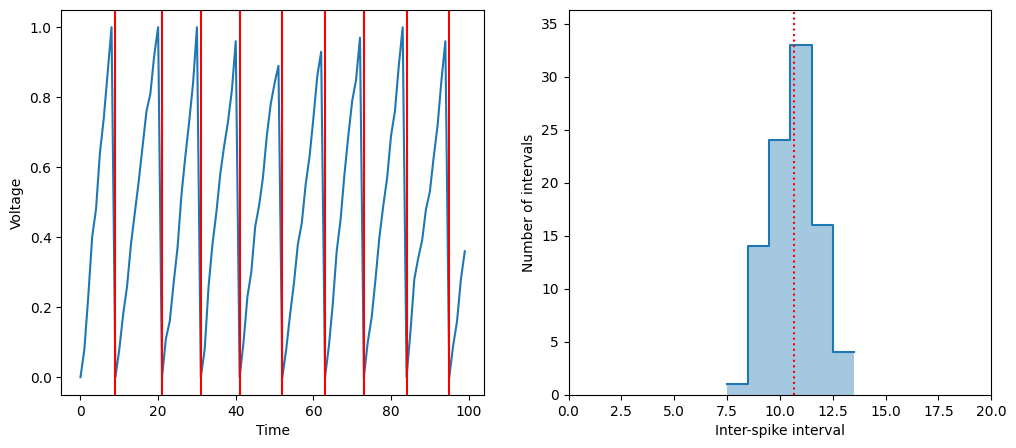

In [17]:
def lif_neuron(n_steps=1000, alpha=0.01, rate=10):
    """ Simulate a linear integrate-and-fire neuron.
  
    Args:
      n_steps (int): The number of time steps to simulate the neuron's activity.
      alpha (float): The input scaling factor
      rate (int): The mean rate of incoming spikes
  
    """
    # Precompute Poisson samples for speed
    exc = stats.poisson(rate).rvs(n_steps)

    # Initialize voltage and spike storage
    v = np.zeros(n_steps)
    spike_times = []

    # Loop over steps
    for i in range(1, n_steps):

        # Update v
        dv = alpha * exc[i] 
        v[i] = v[i-1] + dv

        # If spike happens, reset voltage and record
        if v[i] > 1:
            spike_times.append(i)
            v[i] = 0

    return v, spike_times

# Set random seed (for reproducibility)
np.random.seed(12)

# Model LIF neuron
v, spike_times = lif_neuron()

# Visualize
plot_neuron_stats(v, spike_times)

In [18]:
@widgets.interact(
    alpha=widgets.FloatLogSlider(0.01, min=-2, max=-1),
    rate=widgets.IntSlider(10, min=5, max=20)
)
def plot_lif_neuron(alpha=0.01, rate=10):
    v, spike_times = lif_neuron(2000, alpha, rate)

    plot_neuron_stats(v, spike_times)


# What is the spiking pattern of this model?
# - It rises almost linearly till a threshold and then resets 
# What effect does raising or lowering alpha have?
# - It increases the frequency and reduces the inter-spike interval
# What effect does raising or lowering the rate have?
# - Reduces the requency / the growhth
# Does the distribution of ISIs ever look like what you observed in the data in Tutorial 1?
#- Not really - it's more gaussian than exponential

interactive(children=(FloatLogSlider(value=0.01, description='alpha', max=-1.0, min=-2.0), IntSlider(value=10,…

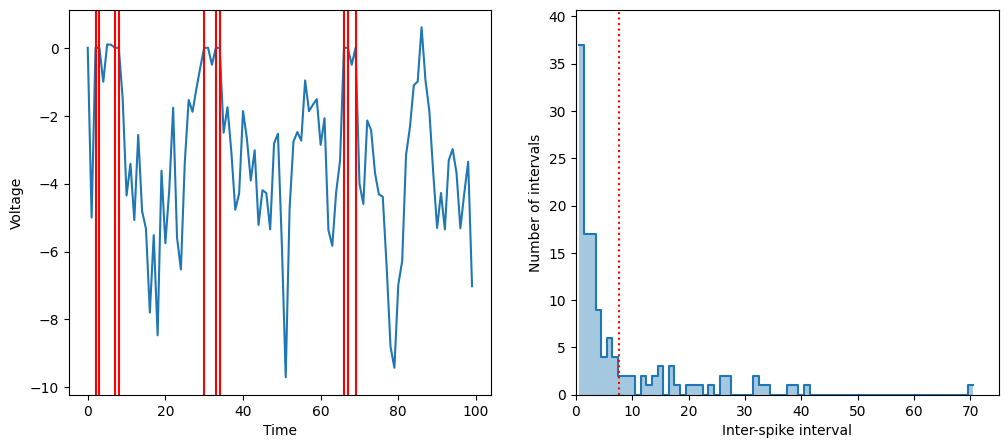

In [19]:
def lif_neuron_inh(n_steps=1000, alpha=0.5, beta=0.1, exc_rate=10, inh_rate=10):
    """ Simulate a simplified leaky integrate-and-fire neuron with both excitatory
    and inhibitory inputs.
  
    Args:
      n_steps (int): The number of time steps to simulate the neuron's activity.
      alpha (float): The input scaling factor
      beta (float): The membrane potential leakage factor
      exc_rate (int): The mean rate of the incoming excitatory spikes
      inh_rate (int): The mean rate of the incoming inhibitory spikes
    """

    # precompute Poisson samples for speed
    exc = stats.poisson(exc_rate).rvs(n_steps)
    inh = stats.poisson(inh_rate).rvs(n_steps)

    v = np.zeros(n_steps)
    spike_times = []

    for i in range(1, n_steps):

        I_i = exc[i] - inh[i]
        dv = -1 * beta * v[i-1] + alpha * I_i

        v[i] = v[i-1] + dv
        if v[i] > 1:
            spike_times.append(i)
            v[i] = 0

    return v, spike_times

# Set random seed (for reproducibility)
np.random.seed(12)

# Model LIF neuron
v, spike_times = lif_neuron_inh()

# Visualize
plot_neuron_stats(v, spike_times)

In [20]:
@widgets.interact(alpha=widgets.FloatLogSlider(0.5, min=-1, max=1),
                  beta=widgets.FloatLogSlider(0.1, min=-1, max=0),
                  exc_rate=widgets.IntSlider(12, min=10, max=20),
                  inh_rate=widgets.IntSlider(12, min=10, max=20))
def plot_lif_neuron(alpha=0.5, beta=0.1, exc_rate=10, inh_rate=10):
    v, spike_times = lif_neuron_inh(2000, alpha, beta, exc_rate, inh_rate)
    plot_neuron_stats(v, spike_times)

interactive(children=(FloatLogSlider(value=0.5, description='alpha', max=1.0, min=-1.0), FloatLogSlider(value=…

# Tutorial 3: Why Models

We are trying to explain why the behavior we have observed in the 'what' and 'how' models are explainable with valid reasons, axioms and relationships.

To do this, we attempt to understand how much *information* is transmitted by a given model - we use *entropy*

We first load in the Steinmetz dataset and define a plotting helper function.

## Framing as an Optimization Problem

- We know that Neurons can only produce a fixed amount of spikes in a given time interval due to metabolic constraints.
- We want to maximize the amount of information we get from our model (i.e entropy) given some number of spikes.

In [21]:
spike_times = np.load(io.BytesIO(open("data/nma_steinmetz_spiketimes_cori_20161214_f32.npz", "rb").read()), allow_pickle=True)["spike_times"]

def plot_pmf(pmf,isi_range):
    """Plot the probability mass function."""
    ymax = max(0.2, 1.05 * np.max(pmf))
    pmf_ = np.insert(pmf, 0, pmf[0])
    plt.plot(bins, pmf_, drawstyle="steps")
    plt.fill_between(bins, pmf_, step="pre", alpha=0.4)
    plt.title(f"Neuron {neuron_idx}")
    plt.xlabel("Inter-spike interval (s)")
    plt.ylabel("Probability mass")
    plt.xlim(isi_range)
    plt.ylim([0, ymax])

### Entropy Function

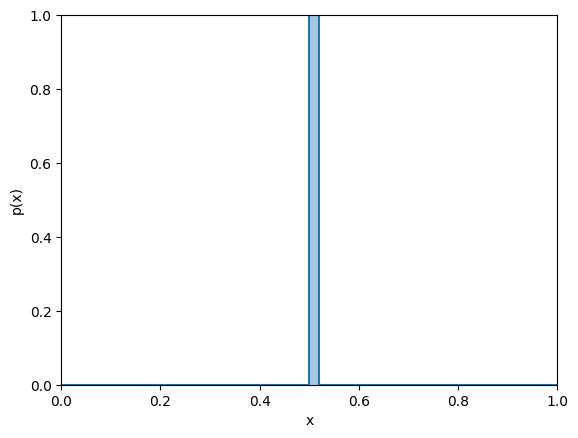

0.00 bits


In [22]:
n_bins = 50  # number of points supporting the distribution
x_range = (0, 1)  # will be subdivided evenly into bins corresponding to points
bins = np.linspace(*x_range, n_bins + 1)  # bin edges
pmf = np.zeros(n_bins)
pmf[len(pmf) // 2] = 1.0  # middle point has all the mass

# Since we already have a PMF, rather than un-binned samples, `plt.hist` is not
# suitable. Instead, we directly plot the PMF as a step function to visualize
# the histogram:
pmf_ = np.insert(pmf, 0, pmf[0])  # this is necessary to align plot steps with bin edges
plt.plot(bins, pmf_, drawstyle="steps")
# `fill_between` provides area shading
plt.fill_between(bins, pmf_, step="pre", alpha=0.4)
plt.xlabel("x")
plt.ylabel("p(x)")
plt.xlim(x_range)
plt.ylim(0, 1)
plt.show()


def entropy(pmf):
    """Given a discrete distribution, return the Shannon entropy in bits.
  
    This is a measure of information in the distribution. For a totally
    deterministic distribution, where samples are always found in the same bin,
    then samples from the distribution give no more information and the entropy
    is 0.
  
    For now this assumes `pmf` arrives as a well-formed distribution (that is,
    `np.sum(pmf)==1` and `not np.any(pmf < 0)`)
  
    Args:
      pmf (np.ndarray): The probability mass function for a discrete distribution
        represented as an array of probabilities.
    Returns:
      h (number): The entropy of the distribution in `pmf`.
    """
    
    # reduce to non-zero entries to avoid an error from log2(0)
    pmf = pmf[pmf > 0] 

    # implement the equation for Shannon entropy (in bits)
    h = -1 * np.sum(pmf * np.log2(pmf))

    # return the absolute value (avoids getting a -0 result)
    return np.abs(h)

# Call entropy function and print result
print(f"{entropy(pmf):.2f} bits")

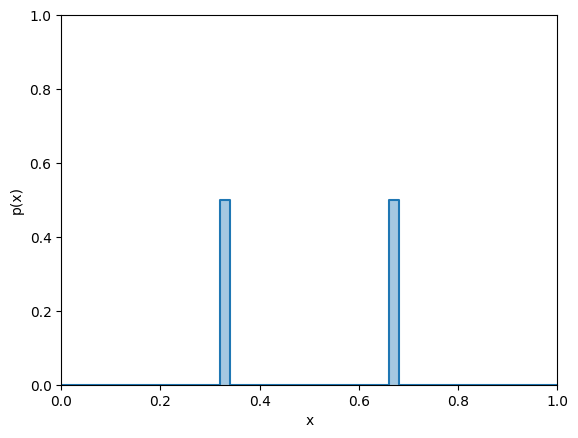

1.00 bits


In [23]:
pmf = np.zeros(n_bins)
pmf[len(pmf) // 3] = 0.5
pmf[2 * len(pmf) // 3] = 0.5

pmf_ = np.insert(pmf, 0, pmf[0])
plt.plot(bins, pmf_, drawstyle="steps")
plt.fill_between(bins, pmf_, step="pre", alpha=0.4)
plt.xlabel("x")
plt.ylabel("p(x)")
plt.xlim(x_range)
plt.ylim(0, 1)
plt.show()

print(f"{entropy(pmf):.2f} bits")


### Uniform Distribution

5.64 bits


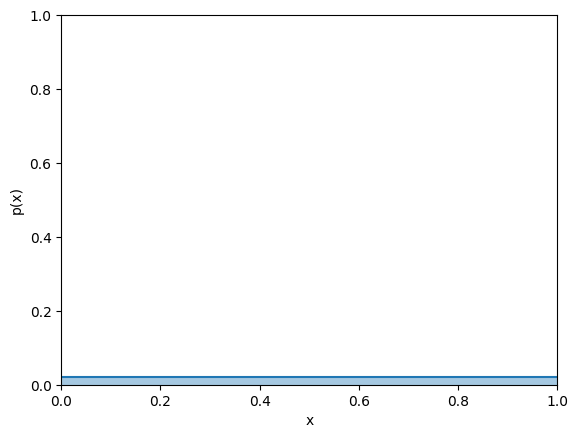

In [24]:
pmf = np.ones(n_bins) / n_bins  # [1/N] * N

pmf_ = np.insert(pmf, 0, pmf[0])
plt.plot(bins, pmf_, drawstyle="steps")
plt.fill_between(bins, pmf_, step="pre", alpha=0.4)
plt.xlabel("x")
plt.ylabel("p(x)")
plt.xlim(x_range)
plt.ylim(0, 1)

print(f"{entropy(pmf):.2f} bits")

### Comparing Entropy across Distributions
"if our neuron has a fixed budget, what ISI distribution should it express (all else being equal) to maximize the information content of its outputs"

In [25]:
n_bins = 50
mean_isi = 0.025
isi_range = (0, 0.25)

bins = np.linspace(*isi_range, n_bins + 1)
mean_idx = np.searchsorted(bins, mean_isi)

# 1. all mass concentrated on the ISI mean
pmf_single = np.zeros(n_bins)
pmf_single[mean_idx] = 1.0

# 2. mass uniformly distributed about the ISI mean
pmf_uniform = np.zeros(n_bins)
pmf_uniform[0:2*mean_idx] = 1 / (2 * mean_idx)

# 3. mass exponentially distributed about the ISI mean
pmf_exp = stats.expon.pdf(bins[1:], scale=mean_isi)
pmf_exp /= np.sum(pmf_exp)

In [26]:
print(
    f"Deterministic: {entropy(pmf_single):.2f} bits",
    f"Uniform: {entropy(pmf_uniform):.2f} bits",
    f"Exponential: {entropy(pmf_exp):.2f} bits",
    sep="\n",
)

Deterministic: 0.00 bits
Uniform: 3.32 bits
Exponential: 3.77 bits


### Calculating the PMF for various ISI models

Entropy for Neuron 283: 3.36 bits


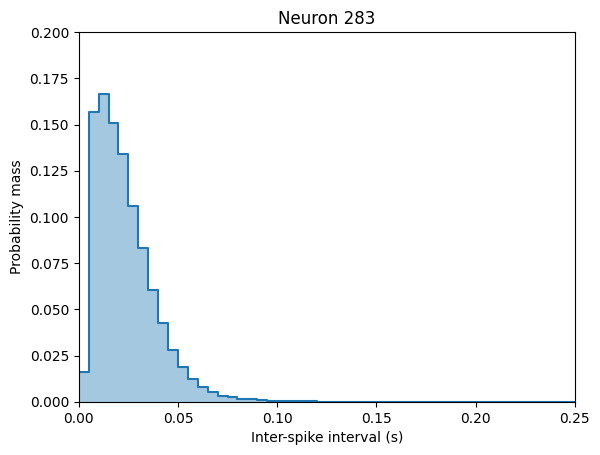

In [27]:
def pmf_from_counts(counts):
    """Given counts, normalize by the total to estimate probabilities."""

    pmf = counts / np.sum(counts)
    
    return pmf


# Get neuron index
neuron_idx = 283

# Get counts of ISIs from Steinmetz data
isi = np.diff(spike_times[neuron_idx])
bins = np.linspace(*isi_range, n_bins + 1)
counts, _ = np.histogram(isi, bins)

# Compute pmf
pmf = pmf_from_counts(counts)

# Visualize
plot_pmf(pmf, isi_range)

print(f"Entropy for Neuron {neuron_idx}: {entropy(pmf):.2f} bits")


In [28]:
@widgets.interact(neuron=widgets.IntSlider(0, min=0, max=(len(spike_times)-1)))
def steinmetz_pmf(neuron):
    """ Given a neuron from the Steinmetz data, compute its PMF and entropy """
    isi = np.diff(spike_times[neuron])
    bins = np.linspace(*isi_range, n_bins + 1)
    counts, _ = np.histogram(isi, bins)
    pmf = pmf_from_counts(counts)

    plot_pmf(pmf, isi_range)
    plt.title(f"Neuron {neuron}: H = {entropy(pmf):.2f} bits")
    plt.show()

interactive(children=(IntSlider(value=0, description='neuron', max=733), Output()), _dom_classes=('widget-inte…

### Questions

- I don't think I understand why Entropy here is telling us something useful about why a particular distribution for Inter Spike Intervals is better or worse.
	- I understand that Entropy is measuring the amount of uncertainty for a distribution - amount of information encoded by that distribution- but why does that tell us something useful about the model? 
- I'm not sure how the concept of Entropy connects back to why this is a Why Models? 
	- How does this explain the underlying essence of why this behavior occurs in the first place?